<h1 style='font-family:georgia;text-align:center'><i>4. Employ the LSTM recurrent neural network (LSTM-RNN) for predicting the exchange rate between US Dollar to Indian Rupee (USD to IRP). </i></h1>

<h2 style='font-family:georgia'>Import Library</h2>

In [1]:
import tensorflow as tf
from tensorflow import keras
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

<h2 style='font-family:georgia'>Load Dataset</h2>

In [2]:
df=pd.read_csv('USD_INR.csv')
df=df.sort_index(ascending=False) #the latest data is at the first index
#take only 1000 last / latest data because 9000 data is too heavy to process
ds=df.tail(1000)
ds

,Date,Price,Open,High,Low,Change %
999,"Oct 11, 2013",61.020,61.200,61.380,60.950,-0.55
998,"Oct 14, 2013",61.555,61.150,61.555,61.125,0.88
997,"Oct 15, 2013",61.840,61.270,61.950,61.270,0.46
996,"Oct 16, 2013",61.735,61.750,61.765,61.720,-0.17
995,"Oct 17, 2013",61.140,61.550,61.740,61.130,-0.96
...,...,...,...,...,...,...
4,"Aug 04, 2017",63.675,63.670,63.786,63.572,-0.05
3,"Aug 07, 2017",63.840,63.710,63.865,63.648,0.26
2,"Aug 08, 2017",63.692,63.750,63.785,63.615,-0.23
1,"Aug 09, 2017",63.860,63.780,63.860,63.710,0.26


<h2 style='font-family:georgia'>Split data</h2>

In [3]:
#predicting the exchange rate
data = ds.filter(['Change %'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .80) #80% train & 20% test

training_data_len

800

<h2 style='font-family:georgia'>Normalize</h2>

In [4]:
scaler = MinMaxScaler(feature_range=(0,1)) #Normalize data
scaled_data = scaler.fit_transform(dataset)

In [5]:
#Windowing every 60 data
train_data = scaled_data[0:training_data_len,:]

x_train=[]
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [6]:
#split train from 3rd cell
x_train, y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(740, 60, 1)

<h2 style='font-family:georgia'>Model</h2>

In [7]:
#initialize LSTM model

model=keras.Sequential()
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer adam
opt = tfa.optimizers.MovingAverage(opt) #smoothing

model.add(keras.layers.LSTM(50, input_shape=(x_train.shape[1],x_train.shape[2])))#input layer
model.add(keras.layers.Dense(50))#hidden layer
model.add(keras.layers.Dense(1))#output layer
model.compile(loss='mse', optimizer=opt) #mean squared error

In [8]:
model.fit(x_train, y_train, epochs=2)

Epoch 1/2
24/24 [==============================] - 3s 25ms/step - loss: 0.0715
Epoch 2/2
24/24 [==============================] - 1s 28ms/step - loss: 0.0185


In [9]:
#split test
test_data = scaled_data[training_data_len - 60:, :]
x_test=[]
y_test= dataset[training_data_len:,:] 
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [10]:
x_test=np.array(x_test) #convert to array
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) #reshape dimension
x_test.shape

(200, 60, 1)

<h2 style='font-family:georgia'>Evaluate</h2>

In [11]:
#predict
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

<h2 style='font-family:georgia'>Visualize</h2>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


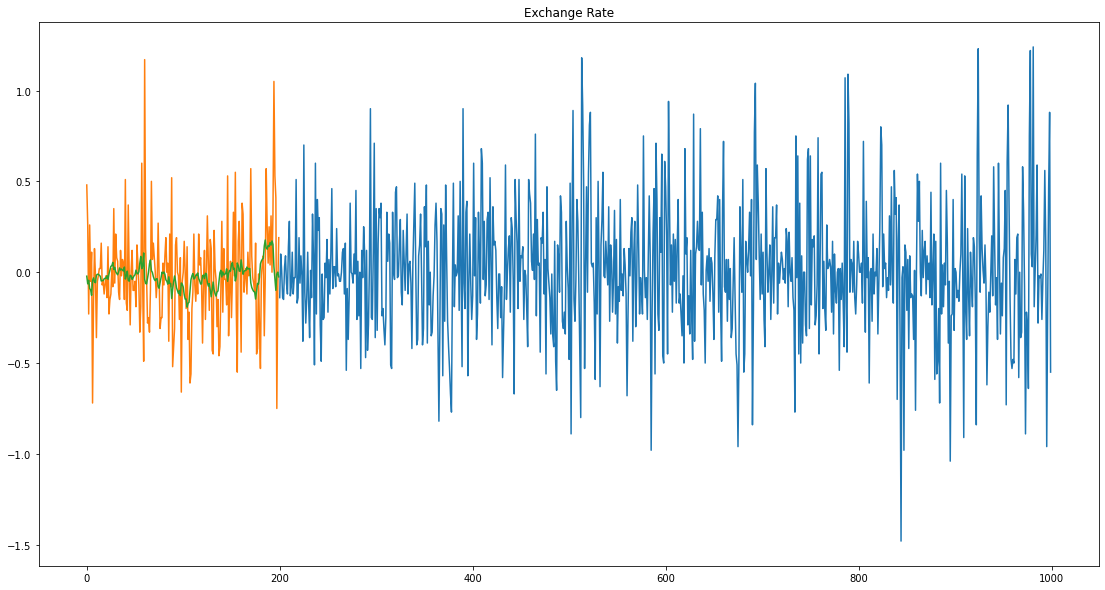

In [12]:
#plot
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(19,10))
plt.title('Exchange Rate')
plt.plot(train['Change %'])
plt.plot(valid[['Change %','Predictions']])
plt.show()